TSM Strategy Return: -6.02%
Max Drawdown: -35.24%


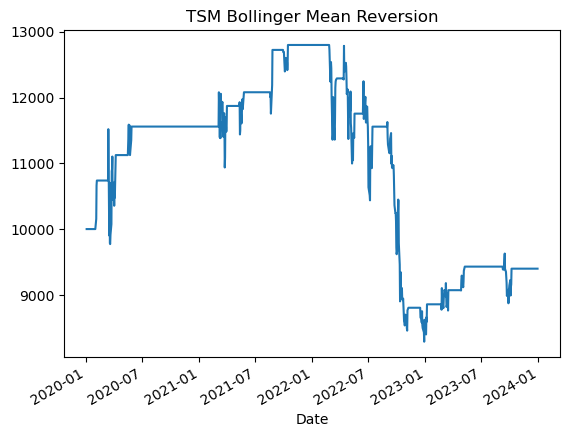

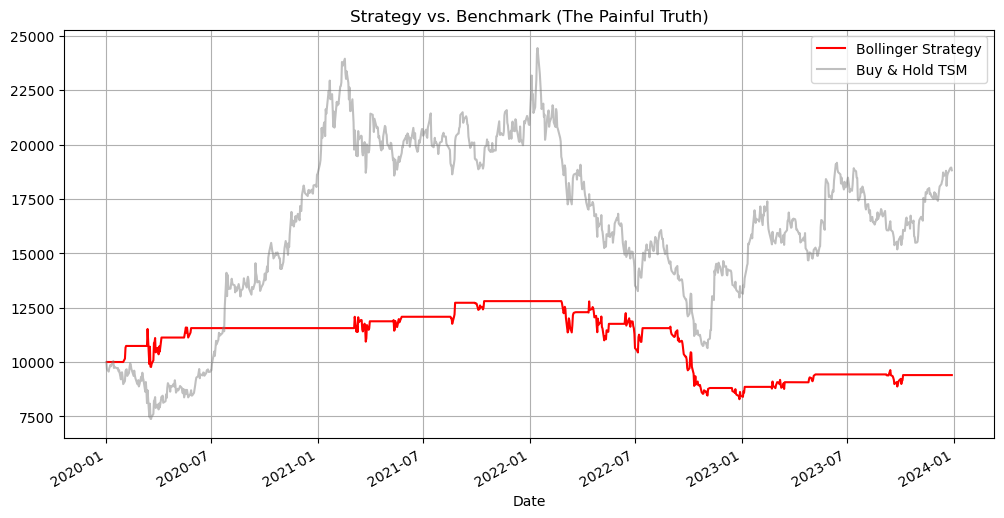

Strategy Return: -6.02%
Benchmark Return: 88.15%


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# === Global Configuration ===
INITIAL_CAPITAL = 10000  # 統一定義在這裡 (通常常數會用全大寫)
COST_BPS = 0.001
# ============================

# 0. 引入你剛寫好的引擎 (假設你在同目錄下有把 run_backtest 存成 .py 或直接複製函數定義)
# from simple_pipeline import run_backtest 
# (或者在此處重新貼上 run_backtest 函數)
# 確保 notebook 讀得到當前目錄
import sys
import os
sys.path.append(os.getcwd()) 

# 引入你的引擎
from simple_pipeline import run_backtest

# 現在你可以直接用了
# results = run_backtest(prices, signal)


# 1. 數據準備
# 下載 TSM 2020-2024 資料
df = yf.download('TSM', start='2020-01-01', end='2024-01-01', progress=False)
# 注意：yfinance 新版回傳可能是 MultiIndex，確保 prices 是 Series (N,)
if isinstance(df.columns, pd.MultiIndex):
    prices = df['Close']['TSM']
else:
    prices = df['Close']

# 2. 計算指標 (Vectorized Indicators)
window = 20
std_devs = 2

# TODO 1: 計算滾動平均 (Moving Average) 和 滾動標準差 (Rolling Std)
# 提示: 使用 .rolling().mean() 和 .rolling().std()
# ma = ...
# std = ...
ma = prices.rolling(window=window).mean()
std = prices.rolling(window=window).std()

# TODO 2: 計算上軌與下軌 (Upper/Lower Bands)
# upper_band = ...
# lower_band = ...
upper_band = ma + std_devs * std
lower_band = ma - std_devs * std

# 3. 生成訊號 (核心挑戰：向量化狀態管理)
# 我們需要產生一個 signal Series，1=持有，0=空手

# 步驟 A: 初始化一個全都是 NaN 的容器 (這是關鍵，不能初始為 0)
signal = pd.Series(np.nan, index=prices.index)

# 步驟 B: 設定「觸發進場」的點 (設為 1)
# 邏輯: 收盤價 < 下軌
# 寫法提示: Boolean Masking
# signal[ ... ] = 1
# TODO 3: 填入進場邏輯
signal[prices < lower_band] = 1

# 步驟 C: 設定「觸發出場」的點 (設為 0)
# 邏輯: 收盤價 > 中軌 (ma)  <-- 均值回歸策略通常回歸均值就跑
# signal[ ... ] = 0
# TODO 4: 填入出場邏輯
signal[prices > ma] = 0

# 步驟 D: 狀態延續 (The Vectorized Magic)
# 思考：現在 signal 裡只有 1 (進場點), 0 (出場點), 和一堆 NaN。
# 我們要讓 NaN 變成「沿用上一次的狀態」。
# TODO 5: 使用 pandas 的 forward fill 函數填補 NaN
# signal = ...
signal = signal.ffill()

# 步驟 E: 處理起始資料 (開頭的 NaN 補 0)
signal = signal.fillna(0)

# 4. 丟入回測引擎
results = run_backtest(prices, signal, initial_capital=INITIAL_CAPITAL, cost_bps=COST_BPS)

# 5. 結果分析
print(f"TSM Strategy Return: {results['total_return']:.2%}")
print(f"Max Drawdown: {results['max_drawdown']:.2%}")

results['equity_curve'].plot(title='TSM Bollinger Mean Reversion')
plt.show()

# ... (接在你原本的 code 後面)

# 1. 計算 Benchmark (買進持有 TSM) 的績效
# 提示: 使用 prices.pct_change() 算出 benchmark_returns
# 然後用 (1 + r).cumprod() 算出 benchmark_equity
# 注意: 起始資金也要乘上去，才能跟策略對比
benchmark_returns = prices.pct_change()
benchmark_equity = INITIAL_CAPITAL * (1 + benchmark_returns.fillna(0)).cumprod()

# 2. 畫圖對比 (Visual Reality Check)
plt.figure(figsize=(12, 6))
results['equity_curve'].plot(label='Bollinger Strategy', color='red')
benchmark_equity.plot(label='Buy & Hold TSM', color='gray', alpha=0.5)

plt.title('Strategy vs. Benchmark (The Painful Truth)')
plt.legend()
plt.grid()
plt.show()

# 3. 算出 Benchmark 的總報酬
bench_return = (benchmark_equity.iloc[-1] / INITIAL_CAPITAL) - 1
print(f"Strategy Return: {results['total_return']:.2%}")
print(f"Benchmark Return: {bench_return:.2%}")

In [ ]:
# === 6. 統計特徵驗證 (Failure Analysis) ===
# 證明市場有肥尾 (Fat Tails)，解釋為什麼 2倍/3倍標準差失效

# 1. 計算 Log Returns (比 pct_change 更適合數學分析)
# 提示: np.log( 本期價格 / 上期價格 )
log_returns = np.log(prices / prices.shift(1)).dropna()

# 2. 驗證一：峰度 (Kurtosis)
# 常態分佈的 Excess Kurtosis = 0
# 如果 > 0，代表發生極端事件的機率比常態分佈高
k_value = log_returns.kurtosis()  # 查 pandas API

print(f"=== Distribution Check ===")
print(f"Excess Kurtosis: {k_value:.4f}")
# 思考：這個數字如果是 5 或 10，代表什麼意義？

# 3. 驗證二：3-Sigma 事件真實頻率
# 理論上 (常態分佈)，發生機率應為 0.27%

mu = log_returns.mean()
sigma = log_returns.std()

# 向量化篩選：找出所有偏離均值超過 3倍標準差 的日子
# 填空: 絕對值(回報 - 均值) > 3 * 標準差
outliers = log_returns[np.abs(log_returns - mu) > 3 * sigma]

# 計算頻率
realized_freq = len(outliers) / len(log_returns)

print(f"Realized 3-Sigma Frequency: {realized_freq:.4%}")
print(f"Theoretical Frequency (Normal): 0.27%")
print(f"Risk Underestimation Multiplier: {realized_freq / 0.0027:.1f}x")

=== Distribution Check ===
Excess Kurtosis: 3.4839
Realized 3-Sigma Frequency: 1.0945%
Theoretical Frequency (Normal): 0.27%
Risk Underestimation Multiplier: 4.1x


In [ ]:
## Stationarity Diagnosis (ADF Test)
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series, name):
    # adfuller 回傳一個 tuple，第二個值才是 p-value
    # result[0] 是 Test Statistic, result[1] 是 p-value
    result = adfuller(series) # 填入要測試的序列
    
    p_value = result[1]
    
    print(f"=== ADF Test for {name} ===")
    print(f"P-Value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("結論: Reject H0 -> Data is STATIONARY (可以用來建模)")
    else:
        print("結論: Fail to Reject H0 -> Data is NON-STATIONARY (禁止直接做回歸)")
    print("-" * 30)

# 1. 測試股價 (Prices)
perform_adf_test(prices, "TSM Prices")

# 2. 測試報酬率 (Log Returns)
perform_adf_test(log_returns, "TSM Log Returns")

=== ADF Test for TSM Prices ===
P-Value: 0.332820
結論: Fail to Reject H0 -> Data is NON-STATIONARY (禁止直接做回歸)
------------------------------
=== ADF Test for TSM Log Returns ===
P-Value: 0.000000
結論: Reject H0 -> Data is STATIONARY (可以用來建模)
------------------------------
